In [3]:
#! kaggle competitions download -c sliced-s01e05-WXx7h8

In [4]:
# Standard stack
import datetime
import pandas as pd
import numpy as np
import re

# Visualization
from pandas_profiling import ProfileReport
#import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import tensorflow as tf
import tensorflow_decision_forests as tfdf
try:
    from wurlitzer import sys_pipes
except:
    from colabtools.googlelog import CaptureLog as sys_pipes

# Scikit-learn packages
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# display
from IPython.core.magic import register_line_magic
from IPython.display import Javascript

# Constants

In [5]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"
label = "price"

# Load Data

In [6]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
submission = pd.read_csv(TEST_PATH)

In [7]:
train.head(1)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,9901706,Cute big one bedroom,1904415,Natalie,Manhattan,Upper West Side,40.77789,-73.97701,Entire home/apt,180,1,0,NaN,NaN,1,0


In [8]:
#train.sample(50)

In [9]:
#train.info()

# Preprocess

### Drop Columns

In [10]:
to_drop = ['id','host_id','host_name']

train = train.drop(to_drop,axis=1)
test = test.drop(to_drop,axis=1)

### Missing Values

In [11]:
def inpute_missing(dataset):
    """ 
    Edit this to fix nulls. Default version replaces all int/float with 0
    """
    for col in dataset.columns:
        if dataset[col].dtype not in [str, object]:
            dataset[col] = dataset[col].fillna(0)
    return dataset

train = inpute_missing(train)
test = inpute_missing(test)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34226 entries, 0 to 34225
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            34217 non-null  object 
 1   neighbourhood_group             34226 non-null  object 
 2   neighbourhood                   34226 non-null  object 
 3   latitude                        34226 non-null  float64
 4   longitude                       34226 non-null  float64
 5   room_type                       34226 non-null  object 
 6   price                           34226 non-null  int64  
 7   minimum_nights                  34226 non-null  int64  
 8   number_of_reviews               34226 non-null  int64  
 9   last_review                     27218 non-null  object 
 10  reviews_per_month               34226 non-null  float64
 11  calculated_host_listings_count  34226 non-null  int64  
 12  availability_365                

In [13]:
train['last_review'] = pd.to_datetime(train['last_review'])

In [14]:
train['last_review'].max()

Timestamp('2019-07-08 00:00:00')

### NLP

In [15]:
# ROOM TYPE

In [16]:
def nlp_transforms(dataset):
    """ 
    NLP tranforms here. Default, None...
    """
    dataset['name'] = dataset['name'].fillna("missing")
    dataset['name'] = dataset['name'].str.lower()
    
    
    dataset['neighbourhood_group'] = dataset['neighbourhood_group'].fillna("missing")
    dataset['neighbourhood_group'] = dataset['neighbourhood_group'].str.lower()

    dataset['neighbourhood'] = dataset['neighbourhood'].fillna("missing")
    dataset['neighbourhood'] = dataset['neighbourhood'].str.lower()

    dataset['room_type'] = dataset['room_type'].fillna("missing")
    dataset['room_type'] = dataset['room_type'].str.lower()

    dataset['last_review'] = pd.to_datetime(dataset['last_review'])
    max_date = dataset['last_review'].max()
    dataset['last_review'] = (max_date - dataset['last_review']).dt.days
    
    return dataset

train = nlp_transforms(train)
test = nlp_transforms(test)

In [17]:
def string_tune(x):
    return tf.strings.split(x)

### Computations

In [18]:
train.head(5)

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,cute big one bedroom,manhattan,upper west side,40.77789,-73.97701,entire home/apt,180,1,0,NaN,0.00,1,0
1,feel like you never leave your home,brooklyn,east new york,40.66795,-73.89232,entire home/apt,100,1,119,8.0,1.39,2,289
2,pristine lower east side sanctuary,manhattan,lower east side,40.72007,-73.98946,entire home/apt,133,14,177,66.0,2.82,2,221
3,"luxe, spacious 2br 2ba nr trains",brooklyn,gowanus,40.66862,-73.99260,entire home/apt,260,30,3,1799.0,0.03,1,316
4,1bd brownstone apt in fort greene!,brooklyn,fort greene,40.68935,-73.96950,entire home/apt,120,3,22,1349.0,0.27,1,189


# Tensorf Hub

In [101]:
!pip install --upgrade tensorflow-hub

In [193]:
def prepare_dataset(data):
    
    features = {"name" : data["name"],
                "neighbourhood_group" : data["neighbourhood_group"],
                "neighbourhood" : data["neighbourhood"],
                "latitude" : data["latitude"],
                "longitude" : data["longitude"],
                #"room_type" :  tf.strings.split(data["room_type"]),
                "minimum_nights" : data["minimum_nights"],
                "number_of_reviews" : data["number_of_reviews"],
                "last_review" : data["last_review"],
                "reviews_per_month" : data["reviews_per_month"],
                "calculated_host_listings_count" : data["calculated_host_listings_count"],
                "availability_365" : data["availability_365"]
               }
    
    try:
        label = data['price']
        output = features,label
    except:
        output = features
    
    return output

In [194]:
#X_train, X_test = train_test_split(train,test_size=0.2, random_state=42)

columns = train.columns.tolist()
#columns = ['name','number_of_reviews','price']
train_dataframe = train[columns]
train_dataframe = train_dataframe.to_dict('list')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataframe)

columns = test.columns.tolist()
test_dataframe = test[columns]
test_dataframe = test_dataframe.to_dict('list')
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataframe)


train_ds = train_dataset.batch(64).map(prepare_dataset)
test_ds = test_dataset.batch(64).map(prepare_dataset)

In [196]:
import tensorflow_hub as hub
# NNLM (https://tfhub.dev/google/nnlm-en-dim128/2) is also a good choice.
hub_url = "http://tfhub.dev/google/universal-sentence-encoder/4"
embedding = hub.KerasLayer(hub_url)


In [197]:
sentence = tf.keras.layers.Input(shape=(), name="name", dtype=tf.string)
neighbourhood = tf.keras.layers.Input(shape=(), name="neighbourhood", dtype=tf.string)
neighbourhood_group = tf.keras.layers.Input(shape=(), name="neighbourhood_group", dtype=tf.string)
latitude = tf.keras.layers.Input(shape=(), name="latitude", dtype=tf.float64)
longitude = tf.keras.layers.Input(shape=(), name="longitude", dtype=tf.float64)
minimum_nights = tf.keras.layers.Input(shape=(), name="minimum_nights", dtype=tf.int64)
number_of_reviews = tf.keras.layers.Input(shape=(), name="number_of_reviews", dtype=tf.int64)
last_review = tf.keras.layers.Input(shape=(), name="last_review", dtype=tf.float64)
reviews_per_month = tf.keras.layers.Input(shape=(), name="reviews_per_month", dtype=tf.float64)
calculated_host_listings_count = tf.keras.layers.Input(shape=(), name="calculated_host_listings_count", dtype=tf.int64)
availability_365 = tf.keras.layers.Input(shape=(), name="availability_365", dtype=tf.int64)
embedded_sentence = embedding(sentence)

In [206]:
test_ds

<MapDataset shapes: {name: (None,), neighbourhood_group: (None,), neighbourhood: (None,), latitude: (None,), longitude: (None,), minimum_nights: (None,), number_of_reviews: (None,), last_review: (None,), reviews_per_month: (None,), calculated_host_listings_count: (None,), availability_365: (None,)}, types: {name: tf.string, neighbourhood_group: tf.string, neighbourhood: tf.string, latitude: tf.float32, longitude: tf.float32, minimum_nights: tf.int32, number_of_reviews: tf.int32, last_review: tf.float32, reviews_per_month: tf.float32, calculated_host_listings_count: tf.int32, availability_365: tf.int32}>

In [213]:
raw_inputs = {"name": sentence, 
             } 

processed_inputs = {"embedded_sentence": embedded_sentence, 
                   }
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

model_2 = tfdf.keras.RandomForestModel(
    preprocessing=preprocessor,
    #num_trees=10,
    task = tfdf.keras.Task.REGRESSION)

model_2.compile(metrics=["mean_squared_logarithmic_error"])
model_2.fit(x=train_ds)

/home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:588: UserWarning: Input dict contained keys ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


535/535 [==============================] - 8s 7ms/step


In [214]:
#evaluation = model_2.evaluate(test_ds)

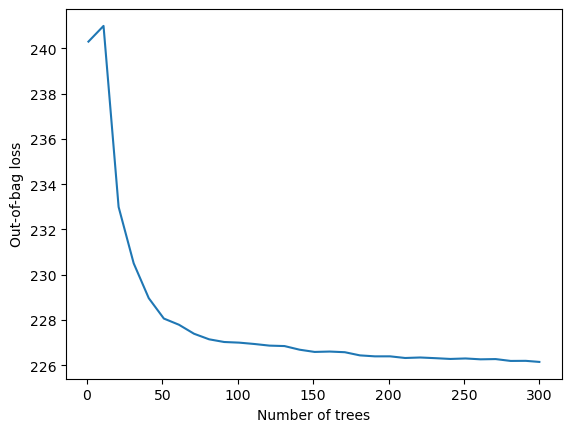

In [215]:
import matplotlib.pyplot as plt

logs =  model_2.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag loss")
plt.show()

In [216]:
1 + 1

2

In [222]:
scores = model_2.predict(train_ds)

In [223]:
train['name_score'] = scores

In [224]:
scores = model_2.predict(test_ds)
test['name_score'] = scores

In [217]:
scores = model_2.predict(test_ds)
#submission['price'] = scores
#submission.head()

In [218]:
submission['price'] = scores
submission.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
0,10449807,Charming Lofty 1bd on Quiet Street,2981910,Daphne,Manhattan,Greenwich Village,40.73466,-73.99539,Entire home/apt,1,0,NaN,NaN,1,0,150.854736
1,1178389,"Beautiful, clean 1-bdrm private apt",6447462,Adam,Manhattan,Washington Heights,40.85060,-73.94023,Entire home/apt,6,19,2017-07-24,0.26,1,188,143.877365
2,23838063,Spacious getaway room in the heart of Bushwick,149073048,Kat,Brooklyn,Bushwick,40.69837,-73.93045,Private room,5,34,2019-06-30,2.31,1,102,96.915741
3,14415799,East Williamsburg Cozy Apartment with Rooftop!,48113730,Anastasia & Jeremy,Brooklyn,Williamsburg,40.70749,-73.93916,Entire home/apt,2,2,2016-10-16,0.06,1,0,142.660446
4,6555262,Comfortable and Spacious Bedroom,14098887,Fareed,Queens,Ridgewood,40.70503,-73.91433,Private room,2,0,NaN,NaN,1,0,75.743675


In [219]:
submit = submission[['id','price']]

In [211]:
submit

,id,price
0,10449807,201.865723
1,1178389,99.244873
2,23838063,79.181549
3,14415799,127.043808
4,6555262,65.899971
...,...,...
14664,30266235,157.386047
14665,22309725,69.853661
14666,25314610,147.172623
14667,6326410,149.093155


In [220]:
submit

,id,price
0,10449807,150.854736
1,1178389,143.877365
2,23838063,96.915741
3,14415799,142.660446
4,6555262,75.743675
...,...,...
14664,30266235,276.204315
14665,22309725,79.405846
14666,25314610,156.196472
14667,6326410,142.300629


In [221]:
submit.to_csv('submission.csv', index=False)
! kaggle competitions submit -c sliced-s01e05-WXx7h8 -f submission.csv -m "Message"

100%|█████████████████████████████████████████| 264k/264k [00:00<00:00, 424kB/s]
Successfully submitted to SLICED s01e05

# Text Train Test Process

In [225]:
#train.info()

In [226]:
columns = train.columns.tolist()
columns

['name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'name_score']

In [245]:
def prepare_dataset(data):
    
    features = {"name" : tf.strings.split(data["name"]),
                "neighbourhood_group" : data["neighbourhood_group"],
                "neighbourhood" : data["neighbourhood"],
                "latitude" : data["latitude"],
                "longitude" : data["longitude"],
                "room_type" :  tf.strings.split(data["room_type"]),
                "minimum_nights" : data["minimum_nights"],
                "number_of_reviews" : data["number_of_reviews"],
                "last_review" : data["last_review"],
                "reviews_per_month" : data["reviews_per_month"],
                "calculated_host_listings_count" : data["calculated_host_listings_count"],
                "availability_365" : data["availability_365"],
                "name_score" : data["name_score"]
               }
    
    try:
        label = data['price']
        output = features,label
    except:
        output = features
    
    return output

In [246]:
#model_1.summary()

In [247]:
#columns

In [248]:
X_train, X_test = train_test_split(train,test_size=0.2, random_state=42)

columns = train.columns.tolist()
#columns = ['name','number_of_reviews','price']
train_dataframe = X_train[columns]
train_dataframe = train_dataframe.to_dict('list')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataframe)

test_dataframe = X_test[columns]
test_dataframe = test_dataframe.to_dict('list')
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataframe)


train_ds = train_dataset.batch(64).map(prepare_dataset)
test_ds = test_dataset.batch(64).map(prepare_dataset)

In [249]:
model_1 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1", task = tfdf.keras.Task.REGRESSION)
model_1.compile(metrics=["mean_squared_logarithmic_error"])
model_1.fit(x=train_ds)

428/428 [==============================] - 0s 636us/step


In [250]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=None, loss=206.2947998046875, rmse=206.2947998046875, ndcg=None, aucs=None)

In [251]:
evaluation = model_1.evaluate(test_ds)
evaluation

107/107 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mean_squared_logarithmic_error: 0.1500


[0.0, 0.15002191066741943]

In [252]:
evaluation = model_1.evaluate(test_ds)
evaluation

107/107 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mean_squared_logarithmic_error: 0.1500


[0.0, 0.15002191066741943]

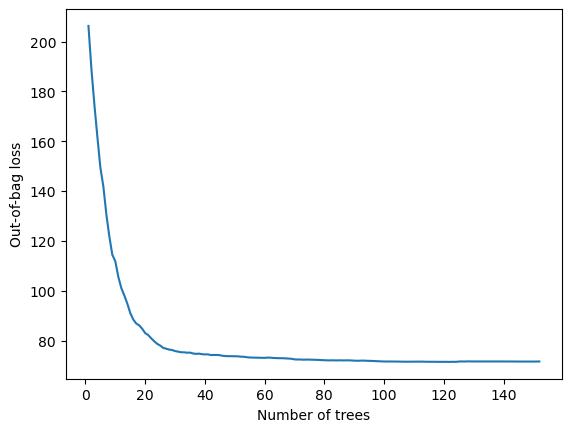

In [253]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag loss")
plt.show()

In [254]:
evaluation

[0.0, 0.15002191066741943]

In [255]:
evaluation

[0.0, 0.15002191066741943]

# Train on Entire Dataset

In [256]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=None, loss=206.2947998046875, rmse=206.2947998046875, ndcg=None, aucs=None)

In [257]:
train_dataframe = train[columns]
train_dataframe = train_dataframe.to_dict('list')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataframe)
train_ds = train_dataset.batch(64).map(prepare_dataset)

In [258]:
model_1 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1", task = tfdf.keras.Task.REGRESSION)
model_1.compile(metrics=["mean_squared_logarithmic_error"])
model_1.fit(x=train_ds)

535/535 [==============================] - 0s 660us/step


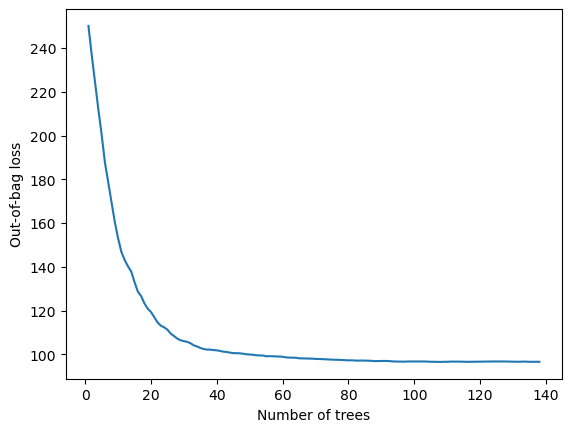

In [259]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Out-of-bag loss")
plt.show()

# Predictions

In [260]:
test

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,name_score
0,charming lofty 1bd on quiet street,manhattan,greenwich village,40.73466,-73.99539,entire home/apt,1,0,NaN,0.00,1,0,150.854736
1,"beautiful, clean 1-bdrm private apt",manhattan,washington heights,40.85060,-73.94023,entire home/apt,6,19,714.0,0.26,1,188,143.877365
2,spacious getaway room in the heart of bushwick,brooklyn,bushwick,40.69837,-73.93045,private room,5,34,8.0,2.31,1,102,96.915741
3,east williamsburg cozy apartment with rooftop!,brooklyn,williamsburg,40.70749,-73.93916,entire home/apt,2,2,995.0,0.06,1,0,142.660446
4,comfortable and spacious bedroom,queens,ridgewood,40.70503,-73.91433,private room,2,0,NaN,0.00,1,0,75.743675
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14664,2nd floor of 2-family house available for dece...,queens,astoria,40.76789,-73.93512,entire home/apt,7,0,NaN,0.00,1,365,276.204315
14665,astoria clean private room,queens,astoria,40.76797,-73.92807,private room,3,0,NaN,0.00,1,0,79.405846
14666,artsy manhattan pied à terre,manhattan,harlem,40.80693,-73.94831,entire home/apt,28,35,18.0,2.72,1,50,156.196472
14667,stylish 1 bed room in the east village,manhattan,east village,40.73069,-73.98515,entire home/apt,3,107,15.0,2.16,1,99,142.300629


In [261]:
columns = test.columns.tolist()

In [262]:
columns

['name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'name_score']

In [263]:
columns = test.columns.tolist()
test_dataframe = test[columns]
test_dataframe = test_dataframe.to_dict('list')
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataframe)
test_ds = test_dataset.batch(64).map(prepare_dataset)

In [265]:
scores = model_1.predict(test_ds)
submission['price'] = scores
submission.head()
submit = submission[['id','price']]
submit.to_csv('submission.csv', index=False)
! kaggle competitions submit -c sliced-s01e05-WXx7h8 -f submission.csv -m "Message"

100%|█████████████████████████████████████████| 263k/263k [00:00<00:00, 305kB/s]
Successfully submitted to SLICED s01e05

In [264]:
scores

array([[179.56618 ],
       [118.56604 ],
       [ 62.007103],
       ...,
       [137.28975 ],
       [172.56496 ],
       [121.161575]], dtype=float32)

In [93]:
scores

array([[249.07463],
       [147.75955],
       [ 62.98694],
       ...,
       [180.7177 ],
       [213.04773],
       [134.0568 ]], dtype=float32)

In [94]:
submission['price'] = scores

In [95]:
submission.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price
0,10449807,Charming Lofty 1bd on Quiet Street,2981910,Daphne,Manhattan,Greenwich Village,40.73466,-73.99539,Entire home/apt,1,0,NaN,NaN,1,0,249.074631
1,1178389,"Beautiful, clean 1-bdrm private apt",6447462,Adam,Manhattan,Washington Heights,40.85060,-73.94023,Entire home/apt,6,19,2017-07-24,0.26,1,188,147.759552
2,23838063,Spacious getaway room in the heart of Bushwick,149073048,Kat,Brooklyn,Bushwick,40.69837,-73.93045,Private room,5,34,2019-06-30,2.31,1,102,62.986938
3,14415799,East Williamsburg Cozy Apartment with Rooftop!,48113730,Anastasia & Jeremy,Brooklyn,Williamsburg,40.70749,-73.93916,Entire home/apt,2,2,2016-10-16,0.06,1,0,147.966339
4,6555262,Comfortable and Spacious Bedroom,14098887,Fareed,Queens,Ridgewood,40.70503,-73.91433,Private room,2,0,NaN,NaN,1,0,58.488190


In [96]:
submit = submission[['id','price']]

In [97]:
submit.head()

,id,price
0,10449807,249.074631
1,1178389,147.759552
2,23838063,62.986938
3,14415799,147.966339
4,6555262,58.488190


In [107]:
submit.head()

,id,price
0,10449807,350.868866
1,1178389,139.080978
2,23838063,68.814850
3,14415799,142.880447
4,6555262,61.425510


In [98]:
submit.to_csv('submission.csv', index=False)

In [99]:
! kaggle competitions submit -c sliced-s01e05-WXx7h8 -f submission.csv -m "Message"

100%|█████████████████████████████████████████| 262k/262k [00:00<00:00, 309kB/s]
Successfully submitted to SLICED s01e05